In [2]:
!pip install tensorflow==2.9.1

     -------------------------------------- 444.1/444.1 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 29.0 MB/s eta 0:00:00
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     --------------------------------------- 24.4/24.4 MB 17.7 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ---------------------------------------- 5.8/5.8 MB 37.1 MB/s eta 0:00:00
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 1.5/1.5 MB 7.9 MB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     ---------------------------------------- 1.6/1.6 MB 11.5 MB/s eta 0:00:00
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-2.2.0-py3-none-any.whl (6.6 kB)
     -------------------------------------- 438.7/438

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LATENT_DIM = 200
EPOCHS = 1
BUFFER_SIZE = 1500

train_dir = r"D:\Winter23\COMP263_DeepLearning_SEC002\Project\Dataset\Train\Mask"

# Load and preprocess images
'''
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True
)'''

# Create a dataset from the image directory
dataset = tf.data.Dataset.list_files(train_dir + "/*")

# Define a function to load and preprocess each image
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = (image - 127.5) / 127.5
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

# Map the load_and_preprocess_image function to each image file path in the dataset
dataset = dataset.map(load_and_preprocess_image)

# Batch the dataset
dataset = dataset.batch(BATCH_SIZE)

# Create an iterator over the dataset
iterator = iter(dataset)

# Get the next image from the iterator
image = next(iterator)

# Print the shape of the image
print("Total no of images: ", len([i for i in iterator]))
print(image.shape)

Total no of images:  15
(32, 224, 224, 3)


In [ ]:
# Create TensorFlow dataset
train_dataset_umapavankumar = tf.data.Dataset.from_tensor_slices(data).shuffle(7000).batch(256)
train_dataset_umapavankumar

In [5]:
# Enable memory growth for GPU acceleration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
        
tf.test.gpu_device_name()

''

In [6]:
# Build generator model
generator_model_umapavankumar = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(200,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

generator_model_umapavankumar.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             2508800   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      5

In [7]:
tf.keras.utils.plot_model(generator_model_umapavankumar, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [8]:
# create sample vector for untrained generator
sample_vector = tf.random.normal(shape=(1, 200))

# generate an image from generator model
generated_image = generator_model_umapavankumar(sample_vector, training=False)

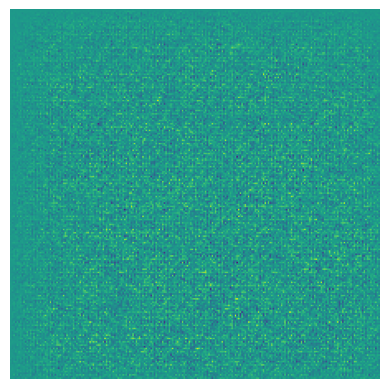

In [9]:
# plot the generated image
plt.imshow(generated_image[0, :, :, 0])#, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
discriminator_model_umapavankumar = tf.keras.Sequential([
    # first convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    # second convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    # output layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

discriminator_model_umapavankumar.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      4864      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 56, 56, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)       

In [11]:
tf.keras.utils.plot_model(discriminator_model_umapavankumar, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [12]:
# Create a loss function for the generator and discriminator
cross_entropy_umapavankumar = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Create optimizers for the generator and discriminator
generator_optimizer_umapavankumar = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer_umapavankumar = tf.keras.optimizers.Adam(1e-4)

In [13]:
# Define the training step function
@tf.function
def training_step(images):
    # Create random noise vector
    noise = tf.random.normal([256, 200])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images from noise
        generated_images = generator_model_umapavankumar(noise, training=True)
        
        # Calculate discriminator output for real and fake images
        real_output = discriminator_model_umapavankumar(images, training=True)
        fake_output = discriminator_model_umapavankumar(generated_images, training=True)
        
        # Calculate the loss for the generator and discriminator
        gen_loss = cross_entropy_umapavankumar(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy_umapavankumar(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy_umapavankumar(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
        
    # Calculate gradients of generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model_umapavankumar.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model_umapavankumar.trainable_variables)
    generator_optimizer_umapavankumar.apply_gradients(zip(gradients_of_generator, generator_model_umapavankumar.trainable_variables))
    discriminator_optimizer_umapavankumar.apply_gradients(zip(gradients_of_discriminator, discriminator_model_umapavankumar.trainable_variables))

In [ ]:
import time

epochs = 10

for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
        training_step(image_batch)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

C:\Users\ASUS\.conda\envs\dl\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Time for epoch 1 is 880.0465955734253 sec
Time for epoch 2 is 762.7828795909882 sec
Time for epoch 3 is 923.8715612888336 sec


In [ ]:
# create 16 sample vectors
generated_vectors = tf.random.normal([16, 200])

predictions = generator_model_umapavankumar(generated_vectors, training=False)

# Normalize the pixels in the generated images
predictions = (predictions * 127.5 + 127.5).numpy()

predictions.shape

In [ ]:
def plot_images(images):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

plot_images(predictions)